My own notebook to play around with the [did](https://github.com/bcallaway11/did) package by Brantly Callaway and Pedro H.C. Sant’Anna. See the vignette [Getting Started with the did Package](https://cran.r-project.org/web/packages/did/vignettes/did-basics.html).

Still very much work in progress!

Notes
 - Used conda environment in the notebook is `dev2023a` from [here](https://github.com/vvoutilainen/dsenvs/blob/main/condaenv.md). *did* package was installed by:
   - First installing *r-ggpubr* to `dev2023a` via conda/mamba. This also downloaded packages *r-pbkrtest*, *r-car*, *r-rstatix*
   - Next, *did* was installed using R's `install.packages()` command with `dependencies=TRUE`. This also installed a few additional packages (*trust*, *BMisc*, *pbapply* , *DRDID*).
 - Repeated cross-section can be created by using `panel=FALSE` in function `build_sim_dataset`

In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
library(did)
set.seed(1814)

In [3]:
def plot_group_means(df):
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(1, 1, 1)
    _ = df.groupby([
        "G",
        "period",
    ]).agg({"Y": "mean"}).reset_index().pivot_table(
        values="Y",
        index="period",
        columns="G"
    ).plot(
        style='.--',
        ax=ax,
    )

def plot_group_cluster_means(df):
    fig = plt.figure(figsize=(8, 4))
    for counter, g in enumerate(df["G"].unique()):
        ax = fig.add_subplot(2, 2, counter+1)
        df.query("G=={}".format(g)).groupby([
            "cluster",
            "period",
        ]).agg({"Y": "mean"}).reset_index().pivot_table(
            values="Y",
            index="period",
            columns="cluster"
        ).plot(
            style='.--',
            legend=False,
            linewidth=0.5,
            markersize=2,
            ax=ax,
        )
        ax.set_title("G = {}".format(g))
    fig.tight_layout()

## Example with vanilla panel two-group, two-period case

In [4]:
%%R -o dta
sp = reset.sim(time.periods=2)
time_periods = 2
dta = build_sim_dataset(sp)
dta = subset(dta, select = -c(cluster) )

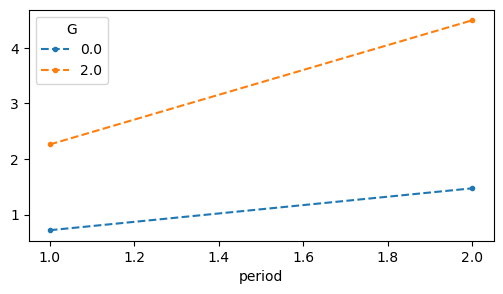

In [5]:
plot_group_means(dta)

In [6]:
# Build model in statsmodels
dta["period_dummy"] = np.where(dta["period"] < 2, 0, 1)
dta["periodxtreatment_dummy"] = dta["period_dummy"] * dta["treat"]
reg_str = "Y ~ 1 + treat + period_dummy + periodxtreatment_dummy"
res = smf.ols(reg_str, data=dta).fit(
    cov_type="cluster",
    cov_kwds={
        "groups": dta["id"],
        "use_correction": False,
    }
)
print("Regression: {}\n".format(reg_str))
print(res.summary())

Regression: Y ~ 1 + treat + period_dummy + periodxtreatment_dummy

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     1255.
Date:                Fri, 12 May 2023   Prob (F-statistic):               0.00
Time:                        16:22:38   Log-Likelihood:                -14822.
No. Observations:                6690   AIC:                         2.965e+04
Df Residuals:                    6686   BIC:                         2.968e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

In [7]:
%%R -i dta
# Repeat using did package, same result
# Warning relates to Wald pre-treatment period test 
out = att_gt(
    yname="Y",
    tname="period",,
    idname="id",
    gname="G",
    bstrap=F,
    panel=T,
    data=dta,
)
summary(out)

R[write to console]: No pre-treatment periods to test




Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    data = dta, panel = T, bstrap = F)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Pointwise  Conf. Band]  
     2    2   1.4811     0.0596          1.3643      1.5979 *
---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Doubly Robust


## Example from the vignette

In [8]:
%%R -o dta,sp
sp = reset.sim()
time_periods = 4
sp$te.e <- 1:time_periods
dta = build_sim_dataset(sp)

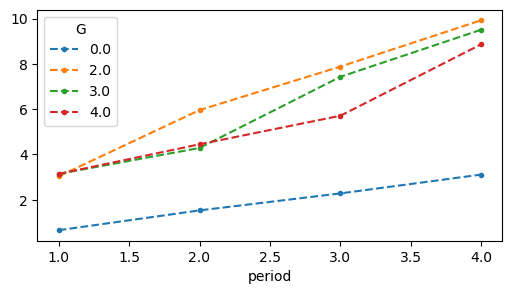

In [9]:
plot_group_means(dta)

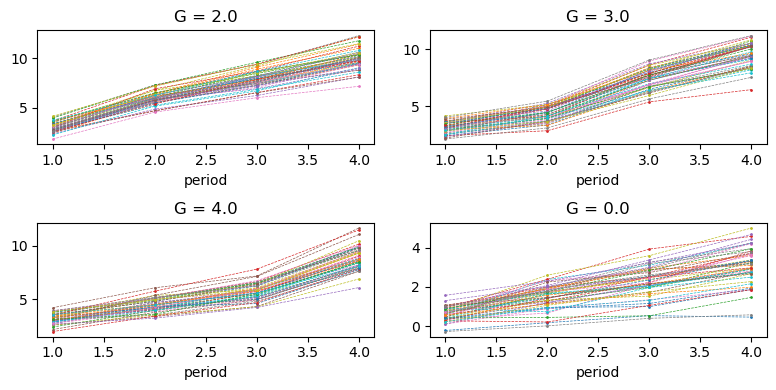

In [10]:
plot_group_cluster_means(dta)

In [11]:
%%R
example_attgt <- att_gt(
    yname = "Y",
    tname = "period",
    idname = "id",
    gname = "G",
    xformla = ~X,
    data = dta
)
summary(example_attgt)


Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    xformla = ~X, data = dta)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
     2    2   1.8506     0.0597        1.6852      2.0161 *
     2    3   2.8229     0.0637        2.6463      2.9995 *
     2    4   3.8488     0.0638        3.6721      4.0256 *
     3    2  -0.0771     0.0600       -0.2434      0.0892  
     3    3   2.0610     0.0606        1.8932      2.2289 *
     3    4   2.9936     0.0645        2.8148      3.1724 *
     4    2  -0.0275     0.0703       -0.2222      0.1671  
     4    3   0.0706     0.0634       -0.1050      0.2461  
     4    4   1.9048     0.0635        1.7288      2.0808 